# Local Differential Privacy (LDP Privacy Enginee ViT)

To ensure data instance-level privacy during local model training on the client side, we'll consider leveraging privacy engines such as `Opacus` 


---

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr 

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.19.0



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../../")

import ray
import time

import torch
import torch.nn as nn

from transformers import ViTForImageClassification

import logging
from logging import ERROR

from opacus.validators import ModuleValidator

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation

from src.config import NUM_CLASSES, ExperimentName
from src.paths import RAY_LOG_DIR
from src.FL_client import MedicalImageClient

from src.FL_server import weighted_average, build_evaluate_fn
from src.local_utility import load_yaml_config, set_device, prepare_FL_dataset, get_weights
from src.privacy_engine import make_fully_opacus_safe_resnet18
from src.tracker import reset_base_memory_csv

In [3]:
# Replace with appropritate values

data_name_ = "skin_lesions" #"alzheimer" #
base_type_ = "vit"
num_labels_ = 8 #Alzheimer-4 & skin_lesions-8 classlabels
exp_name_ = "LDP-PE"
experiment_name_ = ExperimentName.FL_LDP_PE_VIT

In [4]:
DEVICE = set_device()
reset_base_memory_csv() 

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name = exp_name_, data_name = data_name_, base_type=base_type_, augment_data=True)

# Opacus logger seems to change the flwr logger to DEBUG level. Set back to INFO
logging.getLogger("flwr").setLevel(logging.INFO)

In [5]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                      num_labels=num_labels_, 
                                                      ignore_mismatched_sizes=True
                                                      )
    

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(
        model, 
        train_loader, 
        val_loader,
        exp_name = exp_name_,
        data_name = data_name_,
        base_type = base_type_, 
        client_id=partition_id,
        use_privacy_engine = True,
        target_delta = fed_config['dp_params'].get('target_delta'),
        noise_multiplier = fed_config['dp_params'].get('epsilon'),
        max_grad_norm = fed_config['dp_params'].get('max_grad_norm')
        ).to_client()

client = ClientApp(client_fn)

In [6]:
def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                      num_labels=num_labels_, 
                                                      ignore_mismatched_sizes=True
                                                      )
    
    params = ndarrays_to_parameters(get_weights(model))
    
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),         
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )
    
    
    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=fed_config['num_rounds'])
    
    return ServerAppComponents(strategy = strategy, config = sever_config)

# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

In [7]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-07-26 11:50:24,406	INFO worker.py:1771 -- Started a local Ray instance.
2025-07-26 11:50:24,569	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-07-26 11:50:24,675	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_b3017565a4f1a134.zip' (14.90MiB) to Ray cluster...
2025-07-26 11:50:24,717	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_b3017565a4f1a134.zip'.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
[co

(ClientAppActor pid=17833) 
(ClientAppActor pid=17833) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17833) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17833) ⏱️ Total training time: 26 minutes 46 seconds
(ClientAppActor pid=17833) Epsilon value for delta=1e-05 is 7.95


(ClientAppActor pid=17833) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=17833) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=17833) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17833)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) Seed set to 42
(ClientAppActor pid=17833) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessi

(ClientAppActor pid=17832) 
(ClientAppActor pid=17832) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17832) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17832) ⏱️ Total training time: 27 minutes 4 seconds
(ClientAppActor pid=17832) Epsilon value for delta=1e-05 is 7.95


(ClientAppActor pid=17833) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17833)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17833)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) /home/emeka/.local/sh

(ClientAppActor pid=17833) 
(ClientAppActor pid=17833) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17833) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17833) ⏱️ Total training time: 26 minutes 48 seconds
(ClientAppActor pid=17833) Epsilon value for delta=1e-05 is 7.95


INFO :      aggregate_fit: received 3 results and 0 failures
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=16088) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (1, 2.064278970469314, {'accuracy': 0.15333333333333332}, 3257.208227135)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=17833) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifie

(ClientAppActor pid=17833) 
(ClientAppActor pid=17833) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17833) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17833) ⏱️ Total training time: 26 minutes 47 seconds
(ClientAppActor pid=17833) Epsilon value for delta=1e-05 is 7.95


(ClientAppActor pid=17833) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=17833) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=17832) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17832)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) Seed set to 42
(ClientAppActor pid=17833) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessi

(ClientAppActor pid=17832) 
(ClientAppActor pid=17832) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17832) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17832) ⏱️ Total training time: 27 minutes 15 seconds
(ClientAppActor pid=17832) Epsilon value for delta=1e-05 is 7.95


(ClientAppActor pid=17833) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17833)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17833)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) /home/emeka/PrivacyBe

(ClientAppActor pid=17833) 
(ClientAppActor pid=17833) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17833) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17833) ⏱️ Total training time: 26 minutes 48 seconds
(ClientAppActor pid=17833) Epsilon value for delta=1e-05 is 7.95


INFO :      aggregate_fit: received 3 results and 0 failures
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=16088) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (2, 2.0642789725175836, {'accuracy': 0.15333333333333332}, 6515.156823285999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=17832) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'class

(ClientAppActor pid=17833) 
(ClientAppActor pid=17833) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17833) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17833) ⏱️ Total training time: 26 minutes 46 seconds
(ClientAppActor pid=17833) Epsilon value for delta=1e-05 is 7.95


(ClientAppActor pid=17833) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=17833) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=17832) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17832)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) Seed set to 42
(ClientAppActor pid=17833) /home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessi

(ClientAppActor pid=17832) 
(ClientAppActor pid=17832) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17832) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17832) ⏱️ Total training time: 27 minutes 4 seconds
(ClientAppActor pid=17832) Epsilon value for delta=1e-05 is 7.95


(ClientAppActor pid=17833) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17833)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) /home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(ClientAppActor pid=17833)   self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
(ClientAppActor pid=17833) /home/emeka/PrivacyBe

(ClientAppActor pid=17833) 
(ClientAppActor pid=17833) 🔎 Tracker: FL + LDP-PE (ViT)
(ClientAppActor pid=17833) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_LDP-PE_ViT/client_emissions.csv
(ClientAppActor pid=17833) ⏱️ Total training time: 26 minutes 46 seconds
(ClientAppActor pid=17833) Epsilon value for delta=1e-05 is 7.95


INFO :      aggregate_fit: received 3 results and 0 failures
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=16088) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
wandb: Currently logged in as: emyrs to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/wandb/analytics/sentry.py:259: DeprecationWarning: The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.
  self.scope.user = {"email": email}  # noqa
/home/emeka/PrivacyBench/.venv/lib/python3.12/s

/home/emeka/.local/share/uv/python/cpython-3.12.11-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=16088) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



 ___________________________________________________________________________________________________
ExperimentName.FL_LDP_PE_VIT Model Final Evaluation 

Test Accuracy: 15.33% | Precision: 0.30 | Recall: 0.15 | F1-Score: 0.19 | ROC-AUC: 0.51 | MCC: 0.00
 


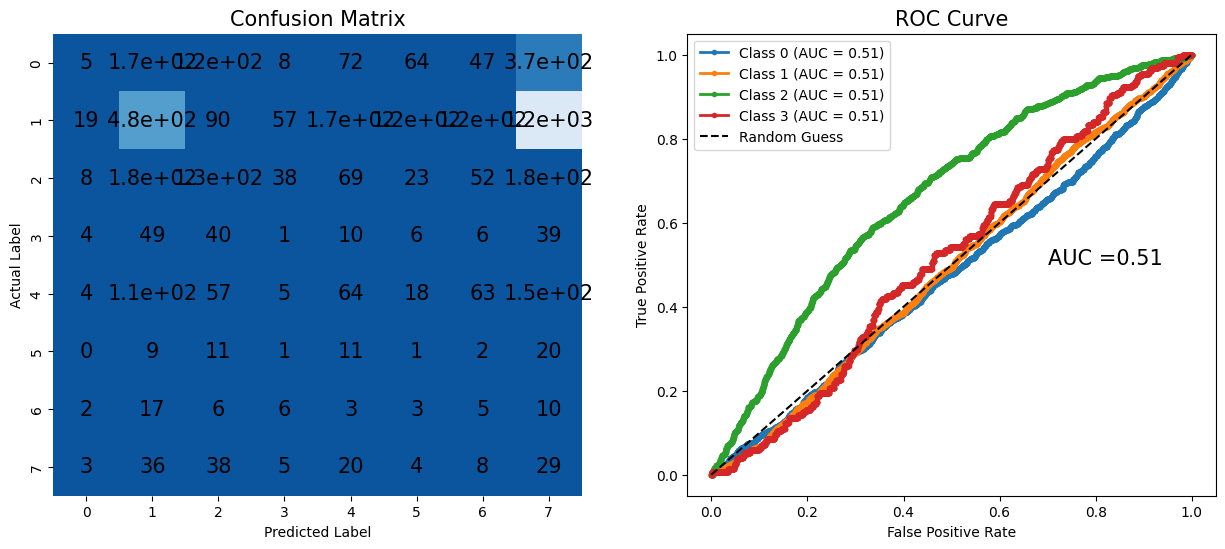


 ___________________________________________________________________________________________________
ExperimentName.FL_LDP_PE_VIT--skin_lesions Model Classification Report
              precision    recall  f1-score   support

           0       0.11      0.01      0.01       853
           1       0.46      0.21      0.29      2242
           2       0.27      0.19      0.22       674
           3       0.01      0.01      0.01       155
           4       0.15      0.13      0.14       476
           5       0.00      0.02      0.01        55
           6       0.02      0.10      0.03        52
           7       0.01      0.20      0.03       143

    accuracy                           0.15      4650
   macro avg       0.13      0.11      0.09      4650
weighted avg       0.30      0.15      0.19      4650

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 14604.09 sec
✅ Total Energy: 0.6

Accuracy,▁
F1-Score,▁
MCC,▁
Peak FL CPU RAM (GB),▁
Peak FL GPU VRAM (GB),▁
Precision,▁
ROC-AUC,▁
Recall,▁
Total FL CO2 Emitted (kg),▁
Total FL Duration (sec),▁
Total FL Energy (kWh),▁


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
INFO :      fit progress: (3, 2.0642789725175836, {'accuracy': 0.15333333333333332}, 9801.927412256)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=17832) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=17832) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(Clien


🕒 Total Time: 164 min 4 sec


In [8]:
project_root =  os.path.abspath("../..")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR),
    num_gpus=2,
    runtime_env={
        "env_vars": {
            "PYTHONWARNINGS": "ignore::DeprecationWarning",  # More specific warning filter
            "OMP_NUM_THREADS": "1"  # Prevents thread oversubscription
        },
        "working_dir": project_root,
        'excludes': ['data', '.cache', '.docker', '.local', 'logs/model']
    },
    ignore_reinit_error=True
)

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"),
    backend_config=backend_setup
)


end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()